<a href="https://colab.research.google.com/github/Luan1511/VNINDEX-Stock-Price-Prediction/blob/main/VNINDEX_Stock_Price_Prediction_best_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # 1- Bussiness Problem

#### Date: Represents the date of the relevant trading day.
#### Open: Represents the starting price of the stock for the relevant trading day.
#### High: Represents the highest price for the relevant trading day.
#### Low: Represents the lowest price for the relevant trading day.
#### Close: Represents the closing price of the stock on the relevant trading day.
#### Adj Close: Represents the adjusted closing price of the stock for the relevant trading day. (This accounts for things like stock splits and dividends.)
#### Volume: Represents the trading volume information for the relevant trading day.

# 2- Understanding Data

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [172]:
import kagglehub

path = kagglehub.dataset_download("keithvo/vnstockdata")

print("Path to dataset files:", path)

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Path to dataset files: /root/.cache/kagglehub/datasets/keithvo/vnstockdata/versions/1
/root/.cache/kagglehub/datasets/keithvo/vnstockdata/versions/1/USDVND1D.csv
/root/.cache/kagglehub/datasets/keithvo/vnstockdata/versions/1/HOSEVN100H4.csv
/root/.cache/kagglehub/datasets/keithvo/vnstockdata/versions/1/HOSEVNINDEXH4.csv
/root/.cache/kagglehub/datasets/keithvo/vnstockdata/versions/1/HOSEVNINDEXH1.csv
/root/.cache/kagglehub/datasets/keithvo/vnstockdata/versions/1/HOSEVN100H1.csv
/root/.cache/kagglehub/datasets/keithvo/vnstockdata/versions/1/HOSEVNINDEXM30.csv
/root/.cache/kagglehub/datasets/keithvo/vnstockdata/versions/1/HOSEVNINDEX1D.csv
/root/.cache/kagglehub/datasets/keithvo/vnstockdata/versions/1/HOSEVN30H1.csv
/root/.cache/kagglehub/datasets/keithvo/vnstockdata/versions/1/HOSEVN30H4.csv
/root/.cache/kagglehub/datasets/keithvo/vnstockdata/versions/1/HOSEVN30M30.csv
/root/.cache/kagglehub/datasets/keithvo/vnstockdata/versions/1/HOSEVN1001D.csv
/root/.cache/kagglehub/datasets/keithvo/v

In [173]:
#data=pd.read_csv("../input/tesla-stock-data-from-2010-to-2020/TSLA.csv")
#data=pd.read_csv('/kaggle/input/tesla-csv/Tasla_Stock_Updated_V2.csv')
# data=pd.read_csv('/kaggle/input/vnindex1/merged_VNINDEX (1).csv')
# data=pd.read_csv('/root/.cache/kagglehub/datasets/keithvo/vnstockdata/versions/1/HOSEVNINDEX1D.csv')
data=pd.read_csv('/root/.cache/kagglehub/datasets/keithvo/vnstockdata/versions/1/HOSEVNINDEXM30.csv')

In [174]:
data.tail()

,time,open,high,low,close,55EMA,89EMA,200EMA,Plot
22159,1733718600,1272.50,1272.65,1272.50,1272.65,1258.222185,1253.035406,1248.058772,NaN
22160,1733724000,1271.91,1272.17,1270.32,1270.46,1258.659250,1253.422619,1248.281669,NaN
22161,1733725800,1270.39,1276.00,1270.24,1275.20,1259.249991,1253.906561,1248.549514,NaN
22162,1733727600,1275.29,1277.69,1272.60,1273.17,1259.747134,1254.334637,1248.794493,NaN
22163,1733729400,1273.10,1273.84,1273.10,1273.84,1260.250451,1254.768090,1249.043702,NaN


In [175]:
def check_df(dataframe,head=5):
    print("#################### Shape #################### ")
    print(dataframe.shape)
    print("#################### Types #################### ")
    print(dataframe.dtypes)
    print("#################### Head #################### ")
    print(dataframe.head(head))
    print("#################### Tail #################### ")
    print(dataframe.dtypes)
    print("#################### NA #################### ")
    print(dataframe.isnull().sum())
    print("#################### Quantiles #################### ")
    print(dataframe.quantile([0,0.5,0.50,0.95,0.99,1]).T)


In [176]:
check_df(data)

#################### Shape #################### 
(22164, 9)
#################### Types #################### 
time        int64
open      float64
high      float64
low       float64
close     float64
55EMA     float64
89EMA     float64
200EMA    float64
Plot      float64
dtype: object
#################### Head #################### 
         time    open    high     low   close  55EMA  89EMA  200EMA  Plot
0  1451872800  579.03  579.46  578.33  579.28    NaN    NaN     NaN   NaN
1  1451874600  579.48  579.97  578.99  579.67    NaN    NaN     NaN   NaN
2  1451876400  579.55  579.55  578.14  578.52    NaN    NaN     NaN   NaN
3  1451878200  579.34  579.34  577.76  577.94    NaN    NaN     NaN   NaN
4  1451880000  577.84  579.32  577.44  579.32    NaN    NaN     NaN   NaN
#################### Tail #################### 
time        int64
open      float64
high      float64
low       float64
close     float64
55EMA     float64
89EMA     float64
200EMA    float64
Plot      float64
dtype: object

#### we need to change the date variable

In [177]:
data["time"]=pd.to_datetime(data["time"], unit="s").dt.strftime('%d/%m/%Y')
data.head()

,time,open,high,low,close,55EMA,89EMA,200EMA,Plot
0,04/01/2016,579.03,579.46,578.33,579.28,NaN,NaN,NaN,NaN
1,04/01/2016,579.48,579.97,578.99,579.67,NaN,NaN,NaN,NaN
2,04/01/2016,579.55,579.55,578.14,578.52,NaN,NaN,NaN,NaN
3,04/01/2016,579.34,579.34,577.76,577.94,NaN,NaN,NaN,NaN
4,04/01/2016,577.84,579.32,577.44,579.32,NaN,NaN,NaN,NaN


In [178]:
data.tail()

,time,open,high,low,close,55EMA,89EMA,200EMA,Plot
22159,09/12/2024,1272.50,1272.65,1272.50,1272.65,1258.222185,1253.035406,1248.058772,NaN
22160,09/12/2024,1271.91,1272.17,1270.32,1270.46,1258.659250,1253.422619,1248.281669,NaN
22161,09/12/2024,1270.39,1276.00,1270.24,1275.20,1259.249991,1253.906561,1248.549514,NaN
22162,09/12/2024,1275.29,1277.69,1272.60,1273.17,1259.747134,1254.334637,1248.794493,NaN
22163,09/12/2024,1273.10,1273.84,1273.10,1273.84,1260.250451,1254.768090,1249.043702,NaN


# 3- Preparing the Data

In [179]:
vnindex_data=data[["time","close"]]
vnindex_data.head()

,time,close
0,04/01/2016,579.28
1,04/01/2016,579.67
2,04/01/2016,578.52
3,04/01/2016,577.94
4,04/01/2016,579.32


In [180]:
print("Min. History:",vnindex_data["time"].min())
print("Max. History:",vnindex_data["time"].max())

Min. History: 01/02/2016
Max. History: 31/12/2021


In [181]:
vnindex_data.index=vnindex_data["time"]
vnindex_data

,time,close
time,,
04/01/2016,04/01/2016,579.28
04/01/2016,04/01/2016,579.67
04/01/2016,04/01/2016,578.52
04/01/2016,04/01/2016,577.94
04/01/2016,04/01/2016,579.32
...,...,...
09/12/2024,09/12/2024,1272.65
09/12/2024,09/12/2024,1270.46
09/12/2024,09/12/2024,1275.20


In [182]:
vnindex_data.drop("time",axis=1,inplace=True)
vnindex_data

,close
time,
04/01/2016,579.28
04/01/2016,579.67
04/01/2016,578.52
04/01/2016,577.94
04/01/2016,579.32
...,...
09/12/2024,1272.65
09/12/2024,1270.46
09/12/2024,1275.20


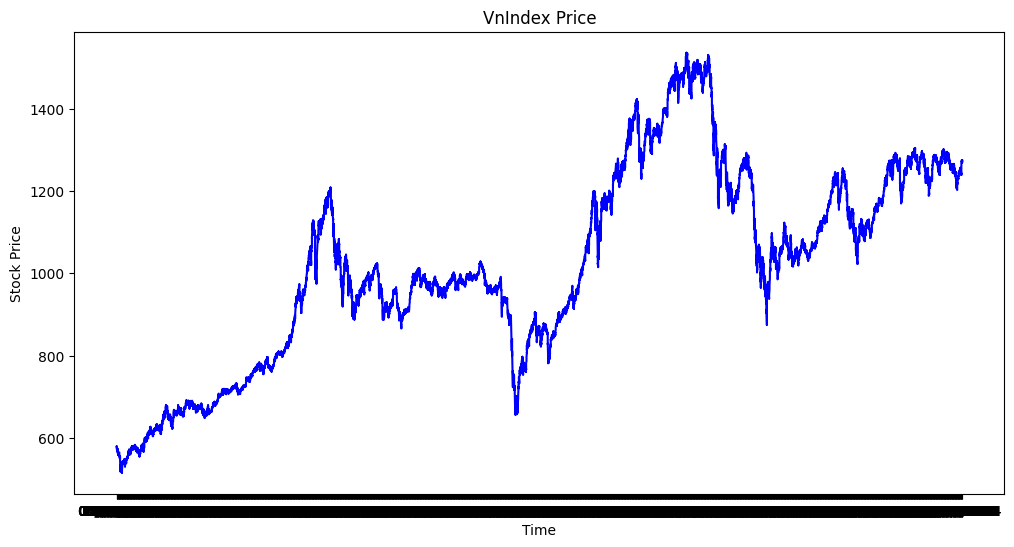

In [183]:
result_data=vnindex_data.copy()
plt.figure(figsize=(12,6))
plt.plot(vnindex_data["close"],color="blue");
plt.ylabel("Stock Price")
plt.title("VnIndex Price")
plt.xlabel("Time")
plt.show()

#### convert to numpy array

In [184]:
vnindex_data=vnindex_data.values
vnindex_data[0:5]

array([[579.28],
       [579.67],
       [578.52],
       [577.94],
       [579.32]])

#### It is necessary to define float 32 for neural network

In [185]:
vnindex_data=vnindex_data.astype("float32")

#### Let's make the Train-Test distinction as a function

In [186]:
def split_data(dataframe,test_size):
    pos=int(round(len(dataframe)*(1-test_size)))
    train=dataframe[:pos]
    test=dataframe[pos:]
    return train,test,pos

train,test,pos=split_data(vnindex_data,0.20)
print(train.shape,test.shape)

(17731, 1) (4433, 1)


In [187]:
scaler_train=MinMaxScaler(feature_range=(0,1))
train=scaler_train.fit_transform(train)
scaler_test=MinMaxScaler(feature_range=(0,1))
test=scaler_test.fit_transform(test)
train[0:5]

array([[0.06247431],
       [0.0628565 ],
       [0.06172937],
       [0.06116086],
       [0.06251347]], dtype=float32)

In [19]:
test[0:5]

array([[0.04381156],
       [0.03195739],
       [0.02183628],
       [0.02204442],
       [0.03036308]], dtype=float32)

In [188]:
def create_features(data,lookback):
    X,Y=[],[]
    for i in range(lookback,len(data)):
        X.append(data[i-lookback:i,0])
        Y.append(data[i,0])
    return np.array(X),np.array(Y)
lookback=180

#### Training Dataset

In [189]:
X_train,y_train=create_features(train,lookback)

#### Testing Dataset

In [190]:
X_test,y_test=create_features(test,lookback)

In [132]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(17551, 180) (17551,) (4253, 180) (4253,)


In [31]:
X_train[0:5]

array([[0.06247431, 0.0628565 , 0.06172937, 0.06116086, 0.06251347,
        0.0626899 , 0.06092566, 0.05770093, 0.05861253, 0.05770093,
        0.05476052, 0.05813223, 0.05528986, 0.05611312, 0.05668163,
        0.05645621, 0.05371183, 0.05426067, 0.05314332, 0.05331975,
        0.05375099, 0.05427045, 0.05480957, 0.05415285, 0.05429989,
        0.05412346, 0.0542019 , 0.05597597, 0.05727947, 0.05785781,
        0.04949719, 0.05335891, 0.05218279, 0.05386859, 0.05162412,
        0.05161428, 0.04716444, 0.04795831, 0.04916394, 0.04883069,
        0.0441162 , 0.0419305 , 0.04539037, 0.04555702, 0.04493952,
        0.04503751, 0.04451805, 0.04236174, 0.04312623, 0.04362613,
        0.0426656 , 0.04173446, 0.04602748, 0.04427302, 0.0435673 ,
        0.04327327, 0.04282242, 0.04306746, 0.04326349, 0.04148942,
        0.041264  , 0.04358691, 0.04289103, 0.04331249, 0.04403776,
        0.04416519, 0.0429498 , 0.04463571, 0.04567462, 0.04775256,
        0.04835039, 0.04784071, 0.04765451, 0.04

#### There are 20 features in total here, so we added the day 20 days before the relevant date to the data set.

In [32]:
y_test[0:5]

array([0.126616  , 0.1163218 , 0.12637353, 0.11309862, 0.11115742],
      dtype=float32)

#### stock closing prices

In [191]:
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(17551, 1, 180) (17551, 1) (4253, 1, 180) (4253, 1)


In [167]:
print(np.isnan(X_train).sum(), np.isnan(y_train).sum())

0 0


# 4- Modeling

Dựa trên kết quả huấn luyện, bạn đã gặp vấn đề với **early stopping** do `val_loss` không cải thiện sau 3 epoch liên tiếp. Điều này có thể xảy ra khi mô hình của bạn bị **overfitting**, **underfitting**, hoặc cấu trúc mô hình và tham số tối ưu chưa phù hợp. Để cải thiện, bạn có thể thực hiện các điều chỉnh sau:

---

### 1. **Điều chỉnh cấu trúc mô hình**:
- **Tăng số lượng đơn vị LSTM**:
  ```python
  model.add(LSTM(units=100, activation="relu", return_sequences=True, input_shape=(X_train.shape[1], lookback)))
  model.add(LSTM(units=50, activation="relu"))
  ```
  Thêm một lớp LSTM với `return_sequences=True` để giữ thông tin qua các bước thời gian.

- **Tăng số tầng Dense**:
  ```python
  model.add(Dense(units=10, activation="relu"))
  model.add(Dense(units=1))
  ```

- **Thử các hàm kích hoạt khác**:
  - `tanh` hoặc `sigmoid` có thể hoạt động tốt với dữ liệu chuỗi thời gian.

---

### 2. **Điều chỉnh tham số tối ưu hóa**:
- **Học suất (learning rate)**:
  Sử dụng `Adam` với learning rate thấp hơn:
  ```python
  from tensorflow.keras.optimizers import Adam
  model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.001))
  ```

- **Thay đổi hàm mất mát**:
  Nếu dữ liệu có outliers, sử dụng hàm `Huber`:
  ```python
  model.compile(loss="huber", optimizer="adam")
  ```

---

### 3. **Cải thiện kỹ thuật huấn luyện**:
- **Tăng patience cho EarlyStopping**:
  ```python
  callbacks = [EarlyStopping(monitor="val_loss", patience=10, verbose=1, mode="min")]
  ```

- **Thay đổi batch_size**:
  Thử nghiệm với các giá trị khác (16, 32, hoặc 64).

- **Shuffling dữ liệu**:
  Nếu dữ liệu không phụ thuộc hoàn toàn vào thứ tự thời gian:
  ```python
  history = model.fit(x=X_train, y=y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks, shuffle=True)
  ```

---

### 4. **Tiền xử lý dữ liệu tốt hơn**:
- **Chuẩn hóa (Normalization)**:
  Chuẩn hóa tất cả các đặc trưng (features) về cùng khoảng giá trị:
  ```python
  from sklearn.preprocessing import MinMaxScaler
  scaler = MinMaxScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  ```

- **Thử nghiệm các giá trị `lookback` khác**:
  Xem xét tăng/giảm số bước thời gian trong quá khứ:
  ```python
  lookback = 30  # Số ngày quá khứ
  ```

---

### 5. **Thử nghiệm các kiến trúc nâng cao**:
- **GRU (Gated Recurrent Units)**:
  GRU thường ít phức tạp hơn LSTM nhưng hiệu quả tương tự:
  ```python
  from tensorflow.keras.layers import GRU
  model.add(GRU(units=50, activation="relu", input_shape=(X_train.shape[1], lookback)))
  ```

- **Attention Mechanism**:
  Thêm cơ chế Attention để cải thiện khả năng học các mẫu phức tạp.

---

### 6. **Theo dõi hiệu suất**:
- Vẽ đồ thị loss và val_loss:
  ```python
  import matplotlib.pyplot as plt
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], lƯabel='Validation Loss')
  plt.legend()
  plt.show()
  ```

Hãy thử từng bước cải thiện trên và quan sát sự thay đổi. Nếu cần thêm hỗ trợ, hãy chia sẻ thông tin về cấu trúc dữ liệu và hiệu suất mô hình hiện tại!

In [192]:
tf.keras.backend.clear_session()

# from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(LSTM(units=120, return_sequences=True, input_shape=(X_train.shape[1], lookback)))
model.add(LSTM(units=60))
model.add(Dropout(0.3))  # Có thể thử Dropout(0.5) nếu cần regularization mạnh hơn
# model.add(Dense(units=10, activation="relu"))
# model.add(Dense(units=64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1))  # Linear phù hợp cho regression
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 120)              │         144,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60)                  │          43,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              61 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 187,981 (734.30 KB)

 Trainable params: 187,981 (734.30 KB)

 Non-trainable params: 0 (0.00 B)

Test other Model

In [49]:
# @title Test
tf.keras.backend.clear_session()
model = Sequential()

# LSTM layer đầu tiên
model.add(LSTM(units=64, return_sequences=False, input_shape=(1, 75)))
model.add(Dropout(0.2))  # Dropout để tránh overfitting

# Dense layer (fully connected)
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))  # Dự đoán đầu ra 1 giá trị

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# In summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          35,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,953 (148.25 KB)

 Trainable params: 37,953 (148.25 KB)

 Non-trainable params: 0 (0.00 B)

#### Setting optimization and evaluation metrics

In [194]:
# from tensorflow.keras.optimizers import Adam
# # model.compile(loss="mean_squared_error",optimizer="adam")
# model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.000005))
# # model.compile(loss="huber", optimizer="adam")
# callbacks=[EarlyStopping(monitor="val_loss",patience=10,verbose=1,mode="min"),
#           ModelCheckpoint(filepath="myModel.keras",monitor="val_loss",mode="min",
#                          save_best_only=True,save_weights_only=False,verbose=1)]

history = model.fit(x=X_train,
                    y=y_train,
                    epochs=100,
                    batch_size=64,
                    validation_data=(X_test,y_test),
                    callbacks=callbacks,
                    shuffle=False)

Epoch 1/100
271/275 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010    
Epoch 1: val_loss improved from 0.00356 to 0.00342, saving model to myModel.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0010 - val_loss: 0.0034
Epoch 2/100
271/275 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0010    
Epoch 2: val_loss did not improve from 0.00342
275/275 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0010 - val_loss: 0.0036
Epoch 3/100
272/275 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010
Epoch 3: val_loss did not improve from 0.00342
275/275 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0010 - val_loss: 0.0036
Epoch 4/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010
Epoch 4: val_loss did not improve from 0.00342
275/275 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 5/100
271/275 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010    
Epoch 5: val_loss did not improve from 0.00342
275/275 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0010 - val_loss: 0.00

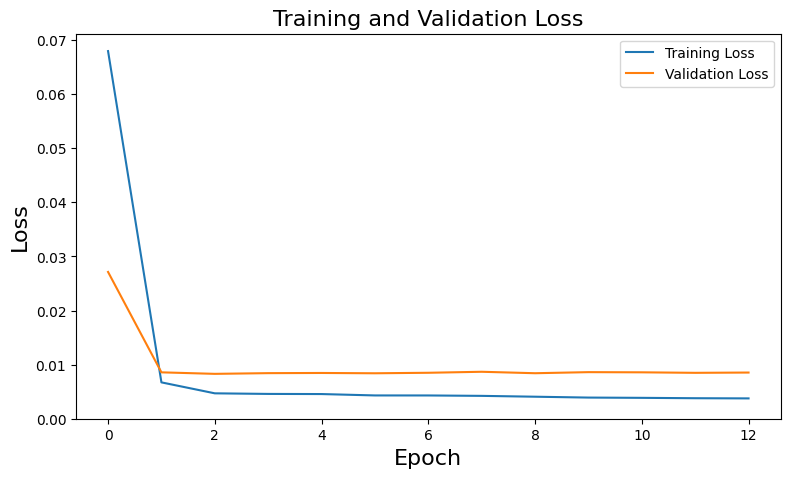

In [156]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title("Training and Validation Loss",fontsize=16)
plt.show()

#### (The expression loss is the mean squared error value, that is, the mean squared expression of the actual values and the estimated values.)

# 5-Evaluation

In [195]:
loss=model.evaluate(X_test,y_test,batch_size=20)

213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0027


In [196]:
print("\nTest loss:%.1f%%"%(100.0*loss))


Test loss:0.4%


In [197]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict=scaler_train.inverse_transform(train_predict)
test_predict=scaler_test.inverse_transform(test_predict)
y_train=scaler_train.inverse_transform(y_train)
y_test=scaler_test.inverse_transform(y_test)

549/549 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


#### RMSE value to train dataset

In [198]:
train_rmse=np.sqrt(mean_squared_error(y_train,train_predict))
test_rmse=np.sqrt(mean_squared_error(y_test,test_predict,))
print(f"Train RMSE:{train_rmse}")
print(f"Test RMSE:{test_rmse}")

Train RMSE:27.27045198139428
Test RMSE:17.271490448835582


#### The mistake that vninedex will be made in the next period is??

In [199]:
train_prediction_data=result_data[lookback:pos]
train_prediction_data["Predicted"]=train_predict
train_prediction_data.tail()

,close,Predicted
time,,
28/02/2023,1028.78,1042.199463
28/02/2023,1028.48,1043.075684
28/02/2023,1032.79,1043.065063
28/02/2023,1031.07,1042.404907
28/02/2023,1028.46,1042.112549


In [200]:
test_prediction_data=result_data[pos+lookback:]
test_prediction_data["Predicted"]=test_predict
test_prediction_data.tail()

,close,Predicted
time,,
09/12/2024,1272.65,1251.144775
09/12/2024,1270.46,1250.551025
09/12/2024,1275.20,1251.098267
09/12/2024,1273.17,1251.531738
09/12/2024,1273.84,1251.028931


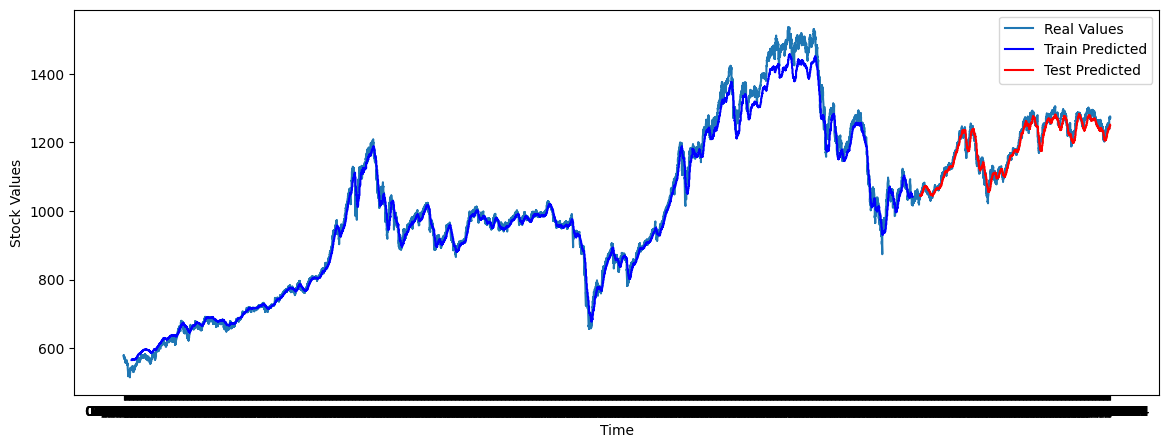

In [201]:
plt.figure(figsize=(14,5))
plt.plot(result_data,label="Real Values")
plt.plot(train_prediction_data["Predicted"],color="blue",label="Train Predicted")
plt.plot(test_prediction_data["Predicted"],color="red",label="Test Predicted")
plt.xlabel("Time")
plt.ylabel("Stock Values")
plt.legend()
plt.show()

### (If we forecast in a certain period, we will conclude that we forecast 32 below or 32 above.)